幅広くデータを見ていく
* 加速度の波形を並べていみる
* ウィンドウフレームごとの平均，分散の変化

In [2]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [3]:
import numpy as np
from numpy import zeros, newaxis
import datetime
import os
import copy
import time

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Parametor about  " Sliding Window " 
WindowWidth =np.array([128,256,512,1024,2048,4096]) # Window Width
SlidingWidth =WindowWidth/4 #sliding window

# Parametor about Neural Network
AEDimention = 16

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"

#chopin
#StorePath = "/home/takeyama/Documents/"
#mozart
StorePath ="/media/takeyama/HD-PNFU3/01_ActivityResearchData/"
if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+DATE+'window/'): 
    os.makedirs(StorePath+TITLE+DATE+'window/')
WindowDataPath=StorePath+TITLE+DATE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'graph/')
GraphPath=StorePath+'/'+TITLE+DATE+'graph/'

センサデータの読み込み

In [4]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する

In [5]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [6]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [7]:
DictName=os.listdir(DictionaryDataPath)

In [8]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

グラフプロットする

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def MakingGraphPath(p):
    if not os.path.exists(GraphPath+p): 
        os.makedirs(GraphPath+p)
    ThisGraphPath=GraphPath+p
    return ThisGraphPath

まずは，加速度Xの周波数領域についてFFTを行う

In [11]:
w=window()
w.SetData('AccX',Sensor1['AccX'])
wind=w.Compile(windowWidth=32,slidingWidth=16)

  0%|          | 0/33682 [00:00<?, ?it/s]

AccX is registed now
Build Complete
Source shape is(1077870,)
window frames num =33682
offset=14


100%|██████████| 33682/33682 [00:17<00:00, 1964.88it/s]


In [12]:
wind = wind.reshape(33683,-1)
wind.shape

(33683, 32)

In [13]:
X = np.fft.fft(wind[1,:])

In [14]:
Outcome = X[1:len(X)/2]

In [15]:
len(wind)

33683

In [16]:
Outcome = Outcome.T

In [17]:
Power_Outcome=Outcome.real**2+Outcome.imag**2

In [18]:
Power_Outcome.shape

(15,)

Participants01のセンサー１のＦＦＴをして，パワースペクトルを求める

In [20]:
Power[0:100,:].shape

(100, 15)

In [21]:
wind.mean()

0.69201098031648023

周波数スペクトルを出してみる,窓関数をハミング窓にする

In [22]:
ThisGraphPath = MakingGraphPath('Sensor1/FFT_AccX_Spectrogram/')

うまく周波数スペクトルが出せないけど，参考になるサイトがあったのでそのコードを載せる
http://stackoverflow.com/questions/34156050/python-matplotlib-specgram-data-array-values-does-not-match-specgram-plot

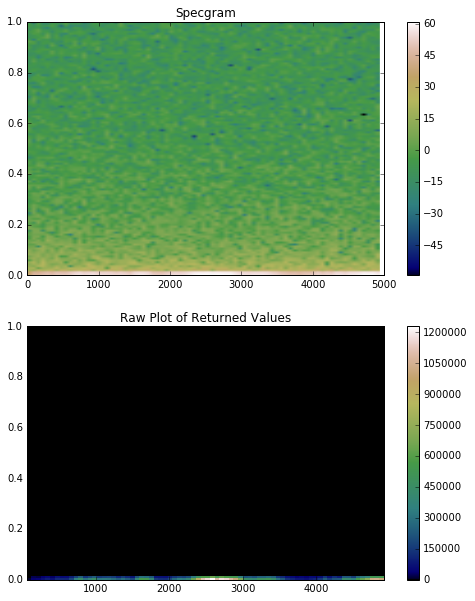

In [36]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# Brownian noise sequence
x = np.random.normal(0, 1, 10000).cumsum()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 10))

values, ybins, xbins, im = ax1.specgram(x, cmap='gist_earth')
ax1.set(title='Specgram')
fig.colorbar(im, ax=ax1)

mesh = ax2.pcolormesh(xbins, ybins, values, cmap='gist_earth')
ax2.axis('tight')
ax2.set(title='Raw Plot of Returned Values')
fig.colorbar(mesh, ax=ax2)

plt.show()

上記の例にセンサデータを試す

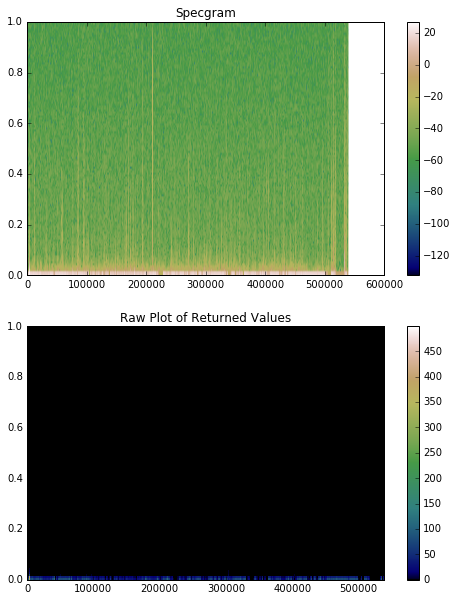

In [34]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# Brownian noise sequence
x = np.random.normal(0, 1, 10000).cumsum()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 10))

values, ybins, xbins, im = ax1.specgram(Sensor1['AccX'], cmap='gist_earth')
ax1.set(title='Specgram')
fig.colorbar(im, ax=ax1)

mesh = ax2.pcolormesh(xbins, ybins, values, cmap='gist_earth')
ax2.axis('tight')
ax2.set(title='Raw Plot of Returned Values')
fig.colorbar(mesh, ax=ax2)

plt.show()

In [32]:
x.shape

(10000,)

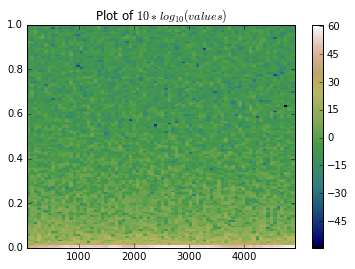

In [29]:
plotted = 10 * np.log10(values)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(xbins, ybins, plotted, cmap='gist_earth')

ax.axis('tight')
ax.set(title='Plot of $10 * log_{10}(values)$')
fig.colorbar(mesh)

plt.show()

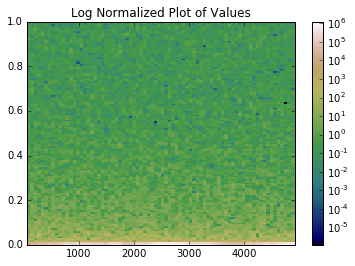

In [30]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
mesh = ax.pcolormesh(xbins, ybins, values, cmap='gist_earth', norm=LogNorm())

ax.axis('tight')
ax.set(title='Log Normalized Plot of Values')
fig.colorbar(mesh)

plt.show()


In [ ]:
# config graph
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')

# config windowFrame
WindowNum=32
SlidingNum=16

w=window()
w.SetData('AccX',Sensor1['AccX'])
wind=w.Compile(windowWidth=WindowNum,slidingWidth=SlidingNum)

ThisGraphPath = MakingGraphPath('Sensor1/FFT_AccX_Power/')

# calcurate FFT
X=  np.fft.fft(wind[0,:])
OutputFFT = np.array( X[1:len(X)/2] )

for i in tqdm_notebook( range(1,len(wind)) ):
    X = np.fft.fft(wind[i,:])
    OutputFFT = np.hstack( (OutputFFT,X[1:len(X)/2]) )
OutputFFT = OutputFFT.T
Power = OutputFFT.real**2+OutputFFT.imag**2

# Graph and FileName
CommonName='FFT'+'_Win='+str(WindowNum).zfill(4)+'_Sld='+str(SlidingNum).zfill(4)+'_'

for PltRng in tqdm_notebook(range(0,33600,100),leave=False,mininterval=5):
    ax.plot(range(PltRng,PltRng+100), Power[PltRng:PltRng+100,:],label='Sensor1-FFT')
    ax.plot(range(PltRng,PltRng+100), Power[PltRng:PltRng+100,:],label='Sensor1-RAW')

    lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

    ax.set_title(CommonName+str( PltRng ).zfill(7)+'-'+str( PltRng+100 ).zfill(7))


    filename = CommonName+str( PltRng ).zfill(7)+'-'+str( PltRng+1000 ).zfill(7)+".png"
    ax.figure.savefig(ThisGraphPath+filename,bbox_extra_artists=(lgnd,), bbox_inches='tight')

    plt.show()
    
    ax.clear()
    time.sleep(0.1)